In [ ]:
!pip install wandb pytorch-lightning #cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [ ]:
import wandb
import torch
from torch import nn
import pytorch_lightning as pl
from functools import lru_cache
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision import models, transforms, datasets

In [ ]:
wandb.login()

In [3]:
pl.seed_everything(42)
project = 'simclr'
max_epochs = 20
size = 32 # 96 for stl10 dataset
jitter_strength = 1
batch_size = 256
out_dim = 128
temp = 0.07
lr = 3e-4
wd = 1e-4

Global seed set to 42


In [4]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage in ('fit', 'validate', None):
            self.train_data = datasets.CIFAR10(self.data_dir, train=True, transform=transforms.ToTensor())
            self.val_data = datasets.CIFAR10(self.data_dir, train=False, transform=transforms.ToTensor())

    @lru_cache(maxsize=128)
    def get_dataloader(self, data, split):
        if split == 'train':
            shuffle = True
        else:
            shuffle = False
        return DataLoader(data, batch_size=self.batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

    def train_dataloader(self):
        return self.get_dataloader(self.train_data, 'train')

    def val_dataloader(self):
        return self.get_dataloader(self.val_data, 'val')

In [5]:
class ModelWrapper(nn.Module):
    def __init__(self, model, out_dim):
        super().__init__()
        # 'model' should be a resnet-like model for this code to work
        model_out_dim = model.fc.in_features
        self.f = nn.Sequential(*list(model.children())[:-1])
        self.g = nn.Sequential(
            nn.Linear(model_out_dim, model_out_dim),
            nn.ReLU(),
            nn.Linear(model_out_dim, out_dim)
        )

    def get_hidden(self, x):
        h = self.f(x) # (bs, 2048, 1, 1)
        h = h.squeeze(-1).squeeze(-1)
        return h

    def forward(self, x):
        h = self.get_hidden(x)
        z = self.g(h)
        return z

In [6]:
class SimCLRModel(pl.LightningModule):
    def __init__(self, model, size, jitter_strength, out_dim, temp, lr, wd):
        super().__init__()
        s = jitter_strength
        self.augmentation = transforms.Compose([
                    transforms.RandomResizedCrop(int(size)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomApply([
                        transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
                    ], p=0.8),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.GaussianBlur(int(0.1*size))
        ])
        self.model = ModelWrapper(model, out_dim)
        self.temp = temp
        self.lr = lr
        self.wd = wd
        self.loss_fn = nn.CrossEntropyLoss()

    def learn(self, x):
        view1 = self.augmentation(x)
        view2 = self.augmentation(x)
        bs = x.shape[0]

        z1 = self.model(view1)
        z2 = self.model(view2)
        z = torch.cat([z1, z2], dim=0)

        # NTXent loss function
        # calculating cosine similarity of l2-normalized tensors
        z = F.normalize(z, dim=1, p=2.0)
        logits = z @ z.T
        mask = torch.eye(2*bs).bool().to(logits.device)
        logits = logits.masked_fill(mask, float('-inf'))
        logits /= self.temp

        # structure of the labels looks like this(for a batch_size of 3):
        # 0 0 0 1 0 0
        # 0 0 0 0 1 0
        # 0 0 0 0 0 1   ->  [3, 4, 5, 0, 1, 2]
        # 1 0 0 0 0 0
        # 0 1 0 0 0 0
        # 0 0 1 0 0 0

        labels = torch.arange(2*bs)
        temp_labels = labels[:bs].clone()
        labels[:bs] = labels[bs:]
        labels[bs:] = temp_labels
        labels = labels.to(logits.device)

        return logits, labels

    def forward(self, x):
        h = self.model.get_hidden(x)
        return h

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        
    def shared_step(self, batch, split):
        x, _ = batch
        logits, labels = self.learn(x)
        loss = self.loss_fn(logits, labels)
        acc = accuracy(logits, labels)
        self.log(f'{split}_loss', loss, on_epoch=True, prog_bar=True)
        self.log(f'{split}_acc', acc, on_epoch=True, prog_bar=True)
        if split == 'train':
            return loss

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        self.shared_step(batch, 'val')

In [7]:
cifar10_dm = CIFAR10DataModule('data/', batch_size)
resnet = models.resnet50()
simclr_model = SimCLRModel(resnet, size, jitter_strength, out_dim, temp, lr, wd)

In [8]:
wandb_logger = pl.loggers.WandbLogger(project=project)
trainer = pl.Trainer(max_epochs=max_epochs, gpus=1, precision=16, logger=wandb_logger, log_every_n_steps=10, deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [9]:
trainer.fit(simclr_model, datamodule=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type             | Params
---------------------------------------------
0 | model   | ModelWrapper     | 28.0 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
111.867   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


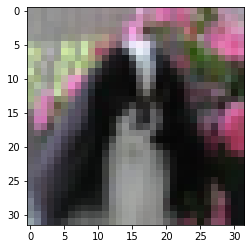

torch.Size([1, 2048])


In [10]:
img, _ = cifar10_dm.val_data[42]
plt.imshow(img.permute(1, 2, 0))
plt.show()

img = img.unsqueeze(0).to(simclr_model.device)
simclr_model.eval()
with torch.no_grad():
    h = simclr_model(img)
print(h.shape)

In [11]:
torch.save(simclr_model.model.f.state_dict(), 'simclr_params.pth')

In [12]:
new_model = models.resnet50()
new_model = nn.Sequential(*list(new_model.children())[:-1]) # f
new_model.load_state_dict(torch.load('simclr_params.pth'))

<All keys matched successfully>